In [1]:
import os
os.chdir("/home/wang/workspace/JupyterNoteBooksAll/fully-automated-multi-heartbeat-echocardiography-video-segmentation-and-motion-tracking")


import echonet
from echonet.datasets import Echo

import torch.nn.functional as F
from torchvision.models.video import r2plus1d_18
from torch.utils.data import Dataset, DataLoader, Subset
from multiprocessing import cpu_count

from src.utils.torch_utils import TransformDataset, torch_collate
from src.transform_utils import generate_2dmotion_field
from src.loss_functions import huber_loss, convert_to_1hot, convert_to_1hot_tensor

from src.model.R2plus1D_18_MotionNet import R2plus1D_18_MotionNet  # ORIGINAL MODEL

# updated models
# dropout not in place, and also might have been in a weird location.
from src.model.dropout_0_10_R2plus1D_18_MotionNet import dropout_0_10_R2plus1D_18_MotionNet 
from src.model.dropout_0_25_R2plus1D_18_MotionNet import dropout_0_25_R2plus1D_18_MotionNet 
from src.model.dropout_0_50_R2plus1D_18_MotionNet import dropout_0_50_R2plus1D_18_MotionNet 
from src.model.dropout_0_75_R2plus1D_18_MotionNet import dropout_0_75_R2plus1D_18_MotionNet 
# dropout? (didn't have forward pass defined, but still saw different outputs??)
from src.model.dropout_v2_0_00_R2plus1D_18_MotionNet import dropout_v2_0_00_R2plus1D_18_MotionNet 
from src.model.dropout_v2_0_10_R2plus1D_18_MotionNet import dropout_v2_0_10_R2plus1D_18_MotionNet 
from src.model.dropout_v2_0_25_R2plus1D_18_MotionNet import dropout_v2_0_25_R2plus1D_18_MotionNet 
from src.model.dropout_v2_0_50_R2plus1D_18_MotionNet import dropout_v2_0_50_R2plus1D_18_MotionNet 
from src.model.dropout_v2_0_75_R2plus1D_18_MotionNet import dropout_v2_0_75_R2plus1D_18_MotionNet 
# dropout with what I think is properly defined behavior in the models.
from src.model.dropout_v3_0_00_R2plus1D_18_MotionNet import dropout_v3_0_00_R2plus1D_18_MotionNet 
from src.model.dropout_v3_0_10_R2plus1D_18_MotionNet import dropout_v3_0_10_R2plus1D_18_MotionNet 
from src.model.dropout_v3_0_25_R2plus1D_18_MotionNet import dropout_v3_0_25_R2plus1D_18_MotionNet 
# multiple dropout layers (4)
from src.model.dropout_v4_0_00_R2plus1D_18_MotionNet import dropout_v4_0_00_R2plus1D_18_MotionNet 
from src.model.dropout_v4_0_10_R2plus1D_18_MotionNet import dropout_v4_0_10_R2plus1D_18_MotionNet 
from src.model.dropout_v4_0_25_R2plus1D_18_MotionNet import dropout_v4_0_25_R2plus1D_18_MotionNet 



from src.echonet_dataset import EchoNetDynamicDataset
from src.clasfv_losses import deformation_motion_loss, motion_seg_loss, DiceLoss, categorical_dice
from src.train_test import train, test, train_with_log, test_with_log

import numpy as np
import matplotlib.pyplot as plt

import random
import pickle
import time

tic, toc = (time.time, time.time)

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim


Tensor = torch.cuda.FloatTensor


# try to make reproducibility easier.
torch.manual_seed(0)
np.random.seed(0)

In [2]:
batch_size = 4
num_workers = max(4, cpu_count()//2)

def worker_init_fn_valid(worker_id):                                                          
    np.random.seed(np.random.get_state()[1][0] + worker_id)
    

def worker_init_fn(worker_id):
    # See here: https://pytorch.org/docs/stable/notes/randomness.html#dataloader
    # and the original post of the problem: https://github.com/pytorch/pytorch/issues/5059#issuecomment-817373837
    worker_seed = torch.initial_seed() % 2 ** 32
    np.random.seed(worker_seed)
    random.seed(worker_seed)
    

def permuter(list1, list2):
    for i1 in list1:
        for i2 in list2:
            yield (i1, i2)
            

param_trainLoader = {'collate_fn': torch_collate,
                     'batch_size': batch_size,
                     'num_workers': max(4, cpu_count()//2),
                     'worker_init_fn': worker_init_fn}

param_testLoader = {'collate_fn': torch_collate,
                    'batch_size': batch_size,
                    'shuffle': False,
                    'num_workers': max(4, cpu_count()//2),
                    'worker_init_fn': worker_init_fn}

paramLoader = {'train': param_trainLoader,
               'valid': param_testLoader,
               'test':  param_testLoader}


with open("fold_indexes/stanford_valid_sampled_indices", "rb") as infile:
    valid_mask = pickle.load(infile)
infile.close()

full_dataset = EchoNetDynamicDataset(split='val', clip_length="full", raise_for_es_ed=False, subset_indices=valid_mask, period=1)
test_dataset = EchoNetDynamicDataset(split='test', clip_length="full", raise_for_es_ed=False, period=1)

print(f'test dataset length: {len(test_dataset)}')


def divide_to_consecutive_clips(video, clip_length=32, interpolate_last=False):
    source_video = video.copy()
    video_length = video.shape[1]
    left = video_length % clip_length
    if left != 0 and interpolate_last:
        source_video = torch.Tensor(source_video).unsqueeze(0)
        source_video = F.interpolate(source_video, size=(int(np.round(video_length / clip_length) * clip_length), 112, 112),
                                     mode="trilinear", align_corners=False)
        source_video = source_video.squeeze(0).squeeze(0)
        source_video = source_video.numpy()
    
    videos = np.empty(shape=(1, 3, clip_length, 112, 112))

    for start in range(0, int(clip_length * np.round(video_length / clip_length)), clip_length):
        one_clip = source_video[:, start: start + clip_length]
        one_clip = np.expand_dims(one_clip, 0)
        videos = np.concatenate([videos, one_clip])
    return videos[1:]


def get_all_possible_start_points(ed_index, es_index, video_length, clip_length):
    assert es_index - ed_index > 0, "not a ED to ES clip pair"
    possible_shift = clip_length - (es_index - ed_index)
    allowed_right = video_length - es_index
    if allowed_right < possible_shift:
        return np.arange(ed_index - possible_shift + 1, video_length - clip_length + 1)
    if possible_shift < 0:
        return np.array([ed_index])
    elif ed_index < possible_shift:
        return np.arange(ed_index + 1)
    else:
        return np.arange(ed_index - possible_shift + 1, ed_index + 1)

100%|██████████| 16/16 [00:01<00:00, 13.96it/s]


test dataset length: 1276


In [3]:
model_names = ['dropout_v3_0_10_R2plus1D_18_MotionNet.pth']

loaded_in_models = []

for model_name in model_names:
    model_save_path = f"save_models/{model_name}"
    
    # original model
    if model_name == "Original_Pretrained_R2plus1DMotionSegNet.pth":
        model_template_obj = R2plus1D_18_MotionNet()
    if model_name == "retrain_original_R2plus1DMotionSegNet.pth":
        model_template_obj = R2plus1D_18_MotionNet()
        
    # # altered models
    # if model_name == "dropout_0_75_R2plus1DMotionSegNet_model.pth":
    #     model = torch.nn.DataParallel(dropout_0_75_R2plus1D_18_MotionNet(), device_ids = [1, 0])
    # if model_name == "dropout_0_50_R2plus1DMotionSegNet_model.pth":
    #     model = torch.nn.DataParallel(dropout_0_50_R2plus1D_18_MotionNet(), device_ids = [1, 0])
    # if model_name == "dropout_0_25_R2plus1DMotionSegNet_model.pth":
    #     model = torch.nn.DataParallel(dropout_0_25_R2plus1D_18_MotionNet(), device_ids = [1, 0])
    # if model_name == "dropout_0_10_R2plus1DMotionSegNet_model.pth":
    #     model = torch.nn.DataParallel(dropout_0_10_R2plus1D_18_MotionNet(), device_ids = [1, 0])
    
    # dropout v2 models
    if model_name == 'dropout_v2_0_00_R2plus1DMotionSegNet_model.pth':
        model = torch.nn.DataParallel(dropout_v2_0_00_R2plus1D_18_MotionNet(), device_ids = [1, 0])
    if model_name == 'dropout_v2_0_10_R2plus1DMotionSegNet_model.pth':
        model = torch.nn.DataParallel(dropout_v2_0_10_R2plus1D_18_MotionNet(), device_ids = [1, 0])
    if model_name == 'dropout_v2_0_25_R2plus1DMotionSegNet_model.pth':
        model = torch.nn.DataParallel(dropout_v2_0_25_R2plus1D_18_MotionNet(), device_ids = [1, 0])
    if model_name == 'dropout_v2_0_50_R2plus1DMotionSegNet_model.pth':
        model = torch.nn.DataParallel(dropout_v2_0_50_R2plus1D_18_MotionNet(), device_ids = [1, 0])
    if model_name == 'dropout_v2_0_75_R2plus1DMotionSegNet_model.pth':
        model = torch.nn.DataParallel(dropout_v2_0_75_R2plus1D_18_MotionNet(), device_ids = [1, 0])
        
    if model_name == "dropout_v3_0_00_R2plus1D_18_MotionNet.pth":
        model_template_obj = dropout_v3_0_00_R2plus1D_18_MotionNet()
    elif model_name == "dropout_v3_0_10_R2plus1D_18_MotionNet.pth":
        model_template_obj = dropout_v3_0_10_R2plus1D_18_MotionNet()
    elif model_name == "dropout_v3_0_25_R2plus1D_18_MotionNet.pth":
        model_template_obj = dropout_v3_0_25_R2plus1D_18_MotionNet()
    elif model_name == "dropout_v4_0_00_R2plus1D_18_MotionNet.pth":
        model_template_obj = dropout_v4_0_00_R2plus1D_18_MotionNet()
    elif model_name == "dropout_v4_0_10_R2plus1D_18_MotionNet.pth":
        model_template_obj = dropout_v4_0_10_R2plus1D_18_MotionNet()
    elif model_name == "dropout_v4_0_25_R2plus1D_18_MotionNet.pth":
        model_template_obj = dropout_v4_0_25_R2plus1D_18_MotionNet()
        
    model = torch.nn.DataParallel(model_template_obj)
    model.to("cuda")
    torch.cuda.empty_cache()
    model.load_state_dict(torch.load(model_save_path)["model"])
    print(f'{model_name} has {sum(p.numel() for p in model.parameters() if p.requires_grad)} parameters.\n')
    model.eval();
    
    loaded_in_models.append((model_name, model))

dropout_v3_0_10_R2plus1D_18_MotionNet.pth has 31575731 parameters.



In [4]:
test_pat_index = 0

video, (filename, EF, es_clip_index, ed_clip_index, es_index, ed_index, es_frame, ed_frame, es_label, ed_label) = test_dataset[test_pat_index]

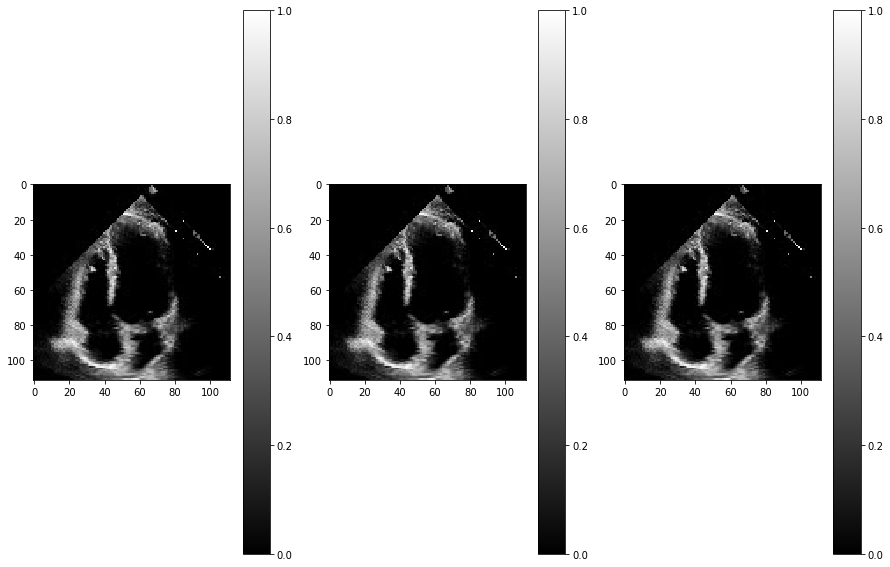

In [5]:
fig, (ax1, ax2, ax3) = plt.subplots(1,3,figsize=(15,10))
ax1_img = ax1.imshow(ed_frame[0], cmap="gray")
fig.colorbar(ax1_img, ax=ax1)
ax2_img = ax2.imshow(ed_frame[1], cmap="gray")
fig.colorbar(ax2_img, ax=ax2)
ax3_img = ax3.imshow(ed_frame[2], cmap="gray")
fig.colorbar(ax3_img, ax=ax3)

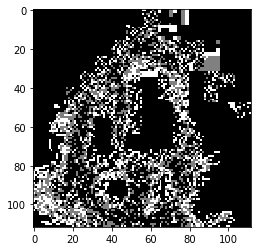

In [6]:
test = np.argmax(ed_frame, 0)
plt.imshow(test, cmap="gray")

In [7]:
np.count_nonzero(ed_frame[0] == 0), np.count_nonzero(ed_frame[0] != 0)

(6826, 5718)

In [8]:
np.count_nonzero(ed_frame[1] == 0), np.count_nonzero(ed_frame[1] != 0)

(6802, 5742)

In [9]:
np.count_nonzero(ed_frame[2] == 0), np.count_nonzero(ed_frame[2] != 0)

(6803, 5741)

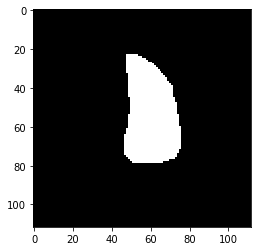

In [10]:
plt.imshow(ed_label, cmap='gray')

In [11]:
ed_label.shape, ed_frame.shape

((112, 112), (3, 112, 112))

## Get Motion Tracking information for our specific video

In [12]:
# get all possible start points (for 32 frame clips)
possible_starts = get_all_possible_start_points(ed_index, es_index, video.shape[1], clip_length=32)

In [13]:
possible_starts, len(possible_starts)

(array([117, 118, 119, 120, 121, 122, 123, 124, 125, 126, 127, 128, 129,
        130, 131, 132]),
 16)

In [14]:
es_index, ed_index

(148, 132)

In [15]:
delta_ed_es = es_index - ed_index
delta_ed_es

16

In [16]:
# segment using all models
all_segmentation_outputs = []
all_motion_outputs = []

# for each model, segment the clips
for name, model in loaded_in_models:

    segmentation_outputs = np.empty(shape=(1, 2, 32, 112, 112))
    motion_outputs = np.empty(shape=(1, 4, 32, 112, 112))
    for start in possible_starts:
        one_clip = np.expand_dims(video[:, start: start + 32], 0)
        segmentation_output, motion_output = model(torch.Tensor(one_clip))
        segmentation_outputs = np.concatenate([segmentation_outputs, segmentation_output.cpu().detach().numpy()])
        motion_outputs = np.concatenate([motion_outputs, motion_output.cpu().detach().numpy()])
    segmentation_outputs = segmentation_outputs[1:]
    motion_outputs = motion_outputs[1:]

    # save 
    all_segmentation_outputs.append(segmentation_outputs)
    all_motion_outputs.append(motion_outputs)

In [17]:
curr_motion_tracking = all_motion_outputs[0]

In [18]:
len(curr_motion_tracking)

16

In [19]:
ed_first_clip_motion_tracking = curr_motion_tracking[-1]

In [20]:
ed_first_clip_motion_tracking.shape

(4, 32, 112, 112)

## Take the ED segmentation frame from seg out

In [21]:
seg_out_ed_frame = all_segmentation_outputs[0][-1]

In [22]:
all_segmentation_outputs[0][-1].shape

(2, 32, 112, 112)

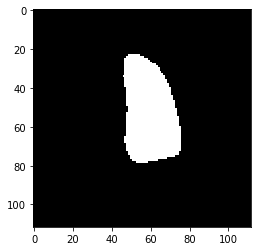

In [23]:
blah = np.argmax(all_segmentation_outputs[0][-1], 0)

ed_frame_blah = blah[0]

plt.imshow(ed_frame_blah, cmap='gray')

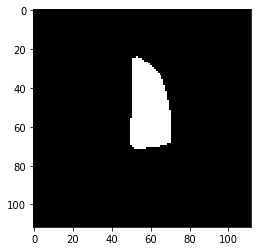

In [24]:
es_frame_blah = blah[delta_ed_es]

plt.imshow(es_frame_blah, cmap='gray')

In [25]:
ed_frame_blah.shape, es_frame_blah.shape

((112, 112), (112, 112))

In [26]:
ed_first_clip_motion_tracking.shape

(4, 32, 112, 112)

## How do we actually do this warp?

### Without looking at Yida's code, let's just mess around and see if we can just do it as "additions"

In [27]:
direction_map = {
    'forward x':0,
    'forward y':1,
    'backward x':2,
    'backward y':3
}

In [28]:
x = ed_frame_blah + ed_first_clip_motion_tracking[0][0]

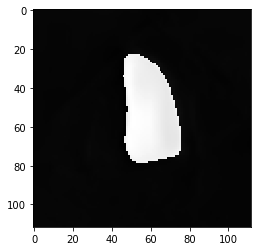

In [29]:
plt.imshow(x, cmap='gray')

In [30]:
# transform ed seg out frame step by step until reach es frame index
# with only 1 dimensional shift
# plt.imshow(ed_frame_blah, cmap='gray')
# plt.show()
# for i in range(delta_ed_es):
#     x = ed_frame_blah + ed_first_clip_motion_tracking[direction_map['forward x']][i]
#     plt.imshow(x, cmap='gray')
#     plt.show()
#     # time.sleep(1)

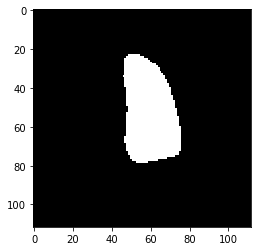

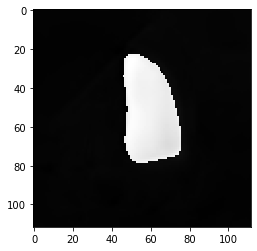

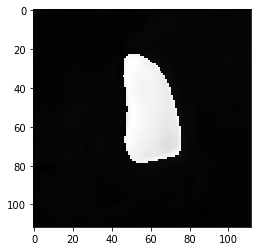

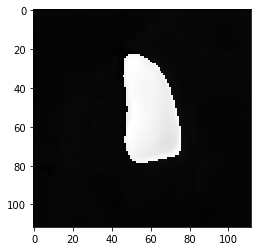

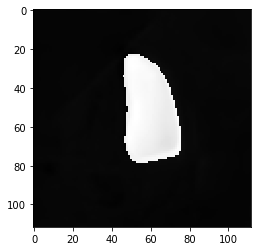

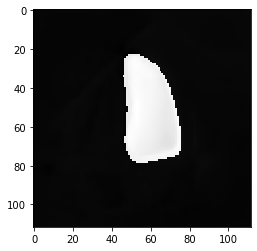

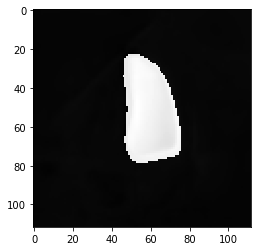

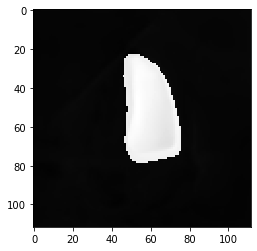

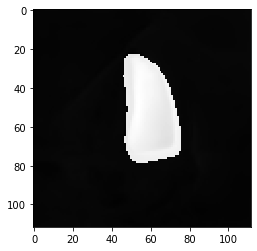

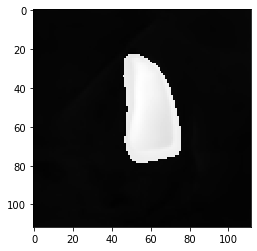

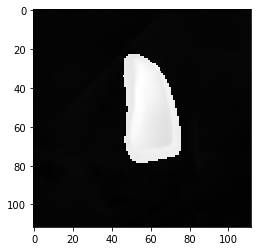

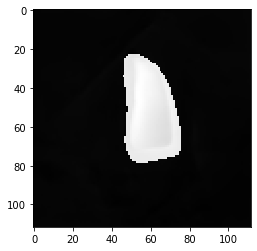

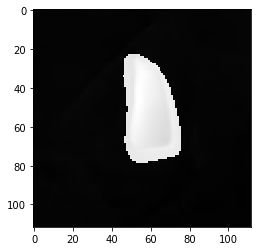

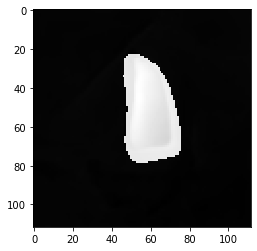

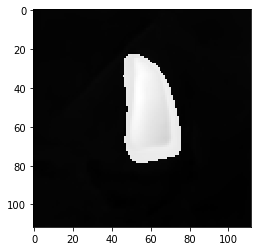

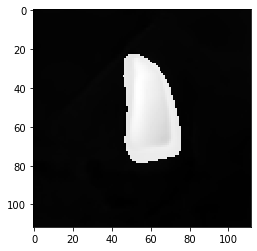

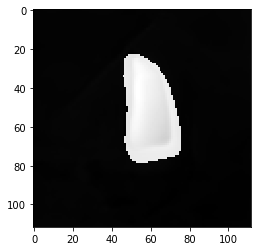

In [31]:
# try to move foward with 2 dimensional shifts (I'm just adding them, I don't know how to differentiate btwn x and y when its just numbers ??)
plt.imshow(ed_frame_blah, cmap='gray')
plt.show()
for i in range(delta_ed_es):
    x = ed_frame_blah + ed_first_clip_motion_tracking[direction_map['forward x']][i] + ed_first_clip_motion_tracking[direction_map['forward y']][i]
    plt.imshow(x, cmap='gray')
    plt.show()
    # time.sleep(1)

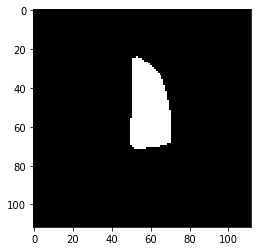

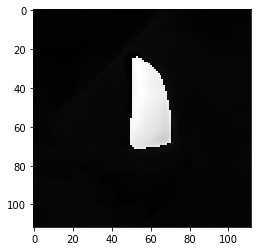

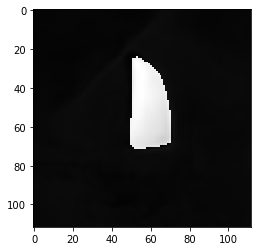

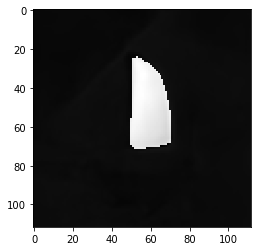

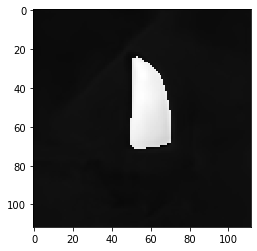

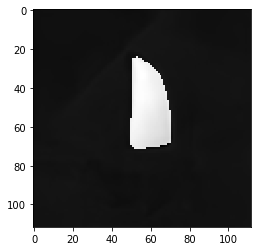

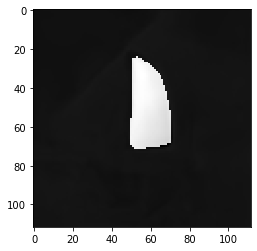

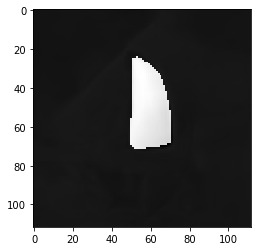

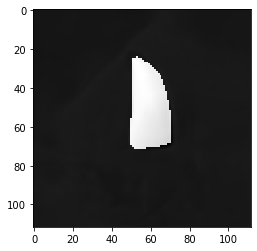

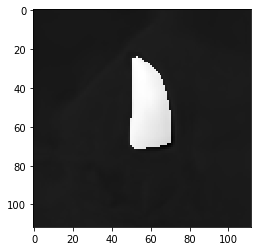

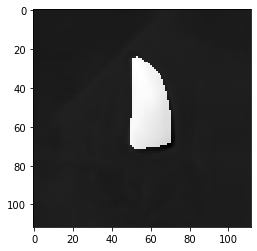

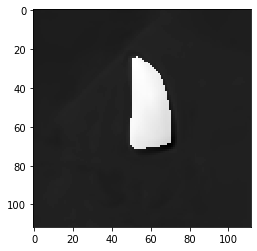

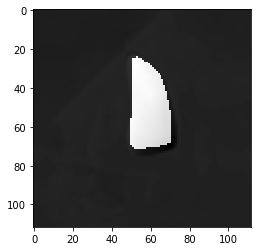

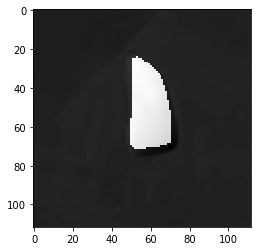

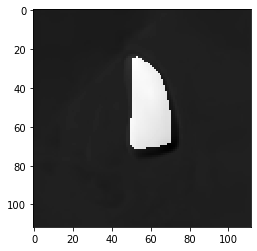

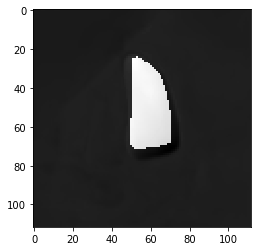

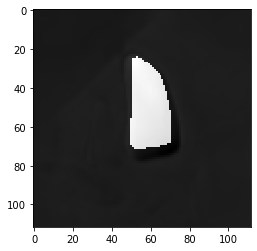

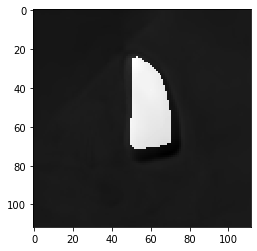

In [32]:
# try to move backwards from es frame to ed
plt.imshow(es_frame_blah, cmap='gray')
plt.show()
for i in range(delta_ed_es, 0 - 1, -1):
    x = es_frame_blah + ed_first_clip_motion_tracking[direction_map['backward x']][i] + ed_first_clip_motion_tracking[direction_map['backward y']][i]
    plt.imshow(x, cmap='gray')
    plt.show()
    # time.sleep(1)

## Problem: How do you interpret a pixel moving by a fraction value? What does that mean?

### Time to go digging into the functions that are used during training to compute a loss using the motion tracking information

#### 1. Start with Train Function

In [ ]:
def train(epoch, train_loader, model, optimizer):
    """ Training function for the network """
    model.train()
    epoch_loss = []
    ed_lv_dice = 0
    es_lv_dice = 0
    
    np.random.seed()
    for batch_idx, batch in enumerate(train_loader, 1):
        video_clips = torch.Tensor(batch[0])
        video_clips = video_clips.type(Tensor)
        filename, EF, es_clip_index, ed_clip_index, es_index, ed_index, es_frame, ed_frame, es_label, ed_label = batch[1]

        optimizer.zero_grad()
        # Get the motion tracking output from the motion tracking head using the feature map
        segmentation_output, motion_output = model(video_clips)
        
        loss = 0
        deform_loss = deformation_motion_loss(video_clips, motion_output)
        loss += deform_loss

        segmentation_loss = 0
        motion_loss = 0
        for i in range(video_clips.shape[0]):
            label_ed = np.expand_dims(ed_label.numpy(), 1).astype("int")
            label_es = np.expand_dims(es_label.numpy(), 1).astype("int")

            label_ed = label_ed[i]
            label_es = label_es[i]

            label_ed = np.expand_dims(label_ed, 0)
            label_es = np.expand_dims(label_es, 0)

            motion_one_output = motion_output[i].unsqueeze(0)
            segmentation_one_output = segmentation_output[i].unsqueeze(0)

            ed_one_index = ed_clip_index[i]
            es_one_index = es_clip_index[i]

            segmentation_one_loss, motion_one_loss = motion_seg_loss(label_ed, label_es, 
                                                                     ed_one_index, es_one_index, 
                                                                     motion_one_output, segmentation_one_output, 
                                                                     0, video_clips.shape[2], 
                                                                     F.binary_cross_entropy_with_logits)
            segmentation_loss += segmentation_one_loss
            motion_loss += motion_one_loss
        loss += (segmentation_loss / video_clips.shape[0])
        loss += (motion_loss / video_clips.shape[0])              
        
        ed_segmentations = torch.Tensor([]).type(Tensor)
        es_segmentations = torch.Tensor([]).type(Tensor)
        for i in range(len(ed_clip_index)):
            ed_one_index = ed_clip_index[i]
            es_one_index = es_clip_index[i]
            
            ed_seg = segmentation_output[i, :, ed_one_index].unsqueeze(0)
            ed_segmentations = torch.cat([ed_segmentations, ed_seg])
            
            es_seg = segmentation_output[i, :, es_one_index].unsqueeze(0)
            es_segmentations = torch.cat([es_segmentations, es_seg])
            
            
        ed_es_seg_loss = 0
        ed_es_seg_loss += F.binary_cross_entropy_with_logits(ed_segmentations, 
                                                             convert_to_1hot(np.expand_dims(ed_label.numpy().astype("int"), 1), 2), 
                                                             reduction="mean") 
        
        ed_es_seg_loss += F.binary_cross_entropy_with_logits(es_segmentations, 
                                                             convert_to_1hot(np.expand_dims(es_label.numpy().astype("int"), 1), 2), 
                                                             reduction="mean") 
        ed_es_seg_loss /= 2
        
        loss += ed_es_seg_loss

        loss.backward()
        
        optimizer.step()
        
        epoch_loss.append(loss.item())
        
        ed_segmentation_argmax = torch.argmax(ed_segmentations, 1).cpu().detach().numpy()
        es_segmentation_argmax = torch.argmax(es_segmentations, 1).cpu().detach().numpy()
            
        ed_lv_dice += categorical_dice(ed_segmentation_argmax, ed_label.numpy(), 1)
        es_lv_dice += categorical_dice(es_segmentation_argmax, es_label.numpy(), 1)
        
        # Printing the intermediate training statistics
        if batch_idx % 280 == 0:
            print('\nTrain Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                epoch, batch_idx * len(video_clips), len(train_loader) * len(video_clips),
                100. * batch_idx / len(train_loader), np.mean(epoch_loss)))

            print("ED LV: {:.3f}".format(ed_lv_dice / batch_idx))
            print("ES LV: {:.3f}".format(es_lv_dice / batch_idx))
            
            print("On a particular batch:")
            print("Deform loss: ", deform_loss)
            print("Segmentation loss: ", ed_es_seg_loss)
            print("Seg Motion loss: ", segmentation_loss / video_clips.shape[0], motion_loss / video_clips.shape[0])
    
    return epoch_loss

### 2. Go into function `motion_seg_loss`, which exists in the python file `src.clasfv_losses`

In [ ]:
def motion_seg_loss(label_ed, label_es, ed_index, es_index, motion_output, seg_softmax, 
                    start=0, end=32, seg_criterion=DiceLoss()):
    """
        SGS loss that spatially transform the true ED and true ES fully forward to the end of video
        and backward to the beginning. Then, compare the forward and backward transformed pseudo labels with
        segmentation at all frames.
    """
    flow_source = convert_to_1hot(label_ed, 2)
    loss_forward = 0
    OTS_loss = 0
    OTS_criterion = DiceLoss()
    
    # Forward from ed to the end of video
    for frame_index in range(ed_index, end - 1):
        forward_motion = motion_output[:, :2, frame_index,...]
        motion_field = generate_2dmotion_field(flow_source, forward_motion)
        next_label = F.grid_sample(flow_source, motion_field, align_corners=False, mode="bilinear", padding_mode='border')
        
        if frame_index == (es_index - 1):
            one_hot_ES = convert_to_1hot(label_es, 2)
            OTS_loss += OTS_criterion(next_label, one_hot_ES)
        else:
            loss_forward += seg_criterion(seg_softmax[:, :, frame_index + 1, ...], next_label)
        flow_source = next_label
    
    # Forward from es to the end of video
    flow_source = convert_to_1hot(label_es, 2)
    for frame_index in range(es_index, end - 1):
        forward_motion = motion_output[:, :2, frame_index,...]
        motion_field = generate_2dmotion_field(flow_source, forward_motion)
        next_label = F.grid_sample(flow_source, motion_field, align_corners=False, mode="bilinear", padding_mode='border')

        loss_forward += seg_criterion(seg_softmax[:, :, frame_index + 1, ...], next_label)
        flow_source = next_label

    flow_source = convert_to_1hot(label_es, 2)
    loss_backward = 0
    
    # Backward from es to the beginning of video
    for frame_index in range(es_index, start, -1):
        backward_motion = motion_output[:, 2:, frame_index,...]
        motion_field = generate_2dmotion_field(flow_source, backward_motion)
        next_label = F.grid_sample(flow_source, motion_field, align_corners=False, mode="bilinear", padding_mode='border')
        
        if frame_index == ed_index + 1:
            one_hot_ED = convert_to_1hot(label_ed, 2)
            OTS_loss += OTS_criterion(next_label, one_hot_ED)
        else:
            loss_backward += seg_criterion(seg_softmax[:, :, frame_index - 1, ...], next_label)
        flow_source = next_label
    
    flow_source = convert_to_1hot(label_ed, 2)
    # Backward from ed to the beginning of video
    for frame_index in range(ed_index, start, -1):
        backward_motion = motion_output[:, 2:, frame_index,...]
        motion_field = generate_2dmotion_field(flow_source, backward_motion)
        next_label = F.grid_sample(flow_source, motion_field, align_corners=False, mode="bilinear", padding_mode='border')
        
        loss_backward += seg_criterion(seg_softmax[:, :, frame_index - 1, ...], next_label)
        flow_source = next_label
        
    # Averaging the resulting dice
    flow_loss = (loss_forward + loss_backward) / ((motion_output.shape[2] - 2) * 2)
    OTS_loss = OTS_loss / 2 
    
    return flow_loss, OTS_loss

### 3. Ok, so let's take a look at just using the `forward x,y` motion to warp segmentation frames

In [ ]:
# Forward from ed to the end of video
for frame_index in range(ed_index, end - 1):
    forward_motion = motion_output[:, :2, frame_index,...]
    motion_field = generate_2dmotion_field(flow_source, forward_motion)
    next_label = F.grid_sample(flow_source, motion_field, align_corners=False, mode="bilinear", padding_mode='border')

    if frame_index == (es_index - 1):
        one_hot_ES = convert_to_1hot(label_es, 2)
        OTS_loss += OTS_criterion(next_label, one_hot_ES)
    else:
        loss_forward += seg_criterion(seg_softmax[:, :, frame_index + 1, ...], next_label)
    flow_source = next_label

### 4. We need to look into 2 functions here, `generate_2dmotion_field(flow_source, forward_motion)` and `F.grid_sample(flow_source, motion_field, align_corners=False, mode="bilinear", padding_mode='border')`

F.grid_sample is from pytorch

`generate_2dmotion_field` is from something we have the source code locally found in `src.transform_utils`

In [ ]:
def generate_2dmotion_field(x, offset):
    # Qin's code for joint_motion_seg learning works fine on our purpose too
    # Same idea https://discuss.pytorch.org/t/warp-video-frame-from-optical-flow/6013/5
    x_shape = x.size()
    grid_w, grid_h = torch.meshgrid([torch.linspace(-1, 1, x_shape[2]), torch.linspace(-1, 1, x_shape[3])])  # (h, w)
    grid_w = grid_w.cuda().float()
    grid_h = grid_h.cuda().float()

    grid_w = nn.Parameter(grid_w, requires_grad=False)
    grid_h = nn.Parameter(grid_h, requires_grad=False)

    offset_h, offset_w = torch.split(offset, 1, 1)
    offset_w = offset_w.contiguous().view(-1, int(x_shape[2]), int(x_shape[3]))  # (b*c, h, w)
    offset_h = offset_h.contiguous().view(-1, int(x_shape[2]), int(x_shape[3]))  # (b*c, h, w)

    offset_w = grid_w + offset_w
    offset_h = grid_h + offset_h
    
    offsets = torch.stack((offset_h, offset_w), 3)

    return offsets

### What are the shapes of the variables that move from function to function?

### Let's grab a batch of data from a `test_loader`, as if we are in the train function, and see how the data flows thru the function and into the motion tracking functions that we are intereste in looking into

In [4]:
test_loader = DataLoader(test_dataset, batch_size=64)

In [6]:
train_dataloader = DataLoader(train_dataset, batch_size=batch_size, 
                              num_workers=num_workers, 
                              shuffle=True, pin_memory=("cuda"), 
                              worker_init_fn=worker_init_fn,
                              drop_last=True)